In [34]:
import ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

np.random.seed(0)

In [35]:
####################
## DATE: April 2024
## AUTHOR: KAITLYN HOHMEIER
# DIRECTIONS

# CDT: signal (probability density) -> L^2. Choose a reference sigma. Then CDT(mu) = T_sigma^mu = Cmu^-1 \circ C_sigma (in 1-D OT, our case, C_sigma will be the identity map; hence, we just have Cmu^-1).

# Step 1: choose interval, create dataset (Gaussians)
# Step 2: define function that takes in mu and outputs Cmu^-1. The function takes in a collection of measures [mu1, ..., mun] and outputs [C1, ..., Cn].
# Make reference measure uniform and then compute CDF: Cr(x) = int^x_{-infty} r = x
# Step 3: Plot data and transform
# Step 4: Apply CDT to all densities in both datasets
# Step 5: Use a linear classifier after applying CDT: PCA, LDA
# Step 6: Use PCA, LDA directly on the original data and compare results

####################

In [36]:
### STEP 1: Create dataset (Gaussians and Gaussian mixtures)
## THE IDEA:
# 1. For each Gaussian, we randomoize mean and standard deviation and choose a fixed interval for the x-axis to draw points from.
# 2. For each Gaussian mixture, we combine a few Gaussians (in the function below, we will choose 2-3 Gaussians) with different weights, randomize the mean and standard deviation for each Gaussian in the mexture, and ensure that the weights are normalized and sum to 1.
# 3. We then generate 200 Gaussians and 200 Gaussian mixtures for our dataset.


# Define helper functions to generate data
def generate_gaussians(num_gaussians, x_range):
  """
  Generates a collection of Gaussians with different means and variances.
  Args:
    num_gaussians (int): The number of Gaussians to generate.
    x_range (tuple): The range of x values to generate data for. This should be a tuple of two numbers (a lower bound and an upper bound).
  Returns:
    A list of Gaussians, each with a different mean and variance. 
  """
  gaussians = []
  for _ in range(num_gaussians):
    mean = np.random.uniform(*x_range)
    std_dev = np.random.uniform(0.1, 2)
    gaussians.append((mean, std_dev))
  return gaussians


def generate_gaussian_mixtures(num_mixtures, x_range, component_range=(2, 3)):
  """
  Generates a collection of Gaussian mixtures with different means and variances.
  Args:
    num_mixtures (int): The number of mixtures to generate.
    x_range (tuple): The range of x values to generate data for. This should be a tuple of two numbers (a lower bound and an upper bound).
    component_range (tuple): The range of component sizes to generate for each mixture. This should be a tuple of two numbers (a lower bound and an upper bound). Basically, this parameter is used to specify the range of possible numbers of individual Gaussian distributions - that is, the components - that can be mixed together to form each Gaussian mixture in the dataset.
  """
  gaussian_mixtures = []
  for _ in range(num_mixtures):
    num_components = np.random.randint(*component_range)
    components = []
    for _ in range(num_components):
      mean = np.random.uniform(*x_range)
      std_dev = np.random.uniform(0.1, 2)
      weight = np.random.random()
      components.append((mean, std_dev, weight))
    # Normalize weights to sum to 1
    total_weight = sum([comp[2] for comp in components])
    components = [(mean, std_dev, weight / total_weight)
                  for (mean, std_dev, weight) in components]
    gaussian_mixtures.append(components)
  return gaussian_mixtures

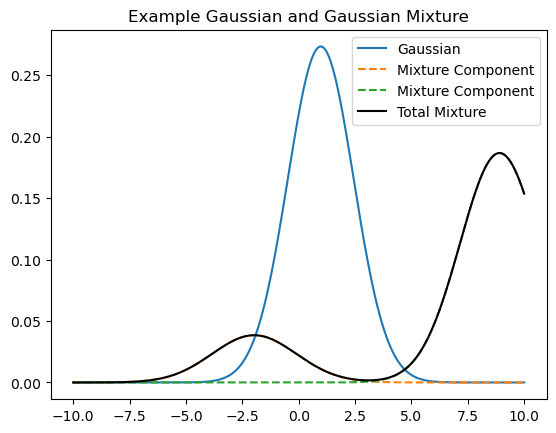

In [37]:
# Implement the functions to obtain the dataset
# Gaussian Parameters
num_gaussians = 200
num_mixtures = 200
x_range = (-10, 10)
# Generate Data
gaussians = generate_gaussians(num_gaussians, x_range)
gaussian_mixtures = generate_gaussian_mixtures(num_mixtures, x_range)
# Example visualization for the first Gaussian and Gaussian Mixture
x_values = np.linspace(*x_range, 400)
# Plot the first Gaussian
mean, std_dev = gaussians[0]
plt.plot(x_values, norm.pdf(x_values, mean, std_dev), label="Gaussian")
# Plot the first Gaussian Mixture
for mean, std_dev, weight in gaussian_mixtures[0]:
  plt.plot(x_values,
           weight * norm.pdf(x_values, mean, std_dev),
           label="Mixture Component",
           linestyle='--')
plt.plot(x_values,
         sum(weight * norm.pdf(x_values, mean, std_dev)
             for mean, std_dev, weight in gaussian_mixtures[0]),
         label="Total Mixture",
         color='black')
plt.legend()
plt.title("Example Gaussian and Gaussian Mixture")
plt.show()

In [38]:
### STEP 2: Define function that takes in each distribution and outputs the CDF and inverse CDF of the distribution.
def compute_cdf_and_inverse_cdf_gaussian(mean_std_dev_tuple, x_values):
  """
  Computes the CDF and inverse CDF for a Gaussian distribution.

  Args:
  mean_std_dev_tuple (tuple): A tuple containing the mean and 
                              standard deviation of the distribution.
  x_values (np.array): An array of x values to compute the CDF.

  Returns:
  tuple: A tuple containing two arrays, the first being the CDF values for 
         the input x_values, and the second being the corresponding inverse 
         CDF values.
  """
  mean, std_dev = mean_std_dev_tuple
  # Compute CDF for the given x values
  cdf_values = norm.cdf(x_values, mean, std_dev)

  # Compute Inverse CDF (quantiles) for equally spaced probabilities
  probabilities = np.linspace(0.01, 0.99, len(x_values))  # Avoiding 0 and 1
  inverse_cdf_values = norm.ppf(probabilities, mean, std_dev)

  return cdf_values, inverse_cdf_values


def compute_gaussian_mixture_cdf_and_inverse(x_values, components):
  """
  Computes the CDF and inverse CDF for a Gaussian mixture distribution.
  Args:
  - x_values (np.array): A range of x values over which to compute the CDF and inverse CDF.
  - components (list): A list of tuples where each tuple contains the mean, standard deviation, and weight of a component Gaussian distribution.
  Returns:
  - cdf (np.array): The CDF values for the given x_values.
  - inverse_cdf (function): An interpolation function that approximates the inverse CDF.
  """
  cdf = sum(weight * norm.cdf(x_values, mean, std_dev)
            for mean, std_dev, weight in components)
  # Clip the CDF values to be strictly between 0 and 1 to avoid extrapolation issues
  cdf_clipped = np.clip(cdf, 0.01, 0.99)
  # Using clipped CDF values for interpolation
  #inverse_cdf = interp1d(cdf_clipped, x_values, fill_value="extrapolate")
  #inverse_cdf = interp1d(cdf, x_values, fill_value="extrapolate")
  inverse_cdf = interp1d(cdf_clipped,
                         x_values,
                         bounds_error=False,
                         fill_value=(x_values[0], x_values[-1]))
  return cdf_clipped, inverse_cdf

In [39]:
# Implement compute_cdf_and_inverse_cdf_gaussian
# Example: First Gaussian
# Compute the inverse CDF for the first Gaussian in the dataset
mean, std = gaussians[
    0]  # Using the first Gaussian's mean and std from dataset
x_range = np.linspace(-10, 10, 400)  # Define the range of x values
# Generate probabilities (avoiding the extreme values of 0 and 1)
probabilities = np.linspace(0.01, 0.99, 400)
# Using the compute_cdf_and_inverse_cdf_gaussian function to obtain inverse CDF values
_, inverse_cdf_values = compute_cdf_and_inverse_cdf_gaussian((mean, std),x_range)

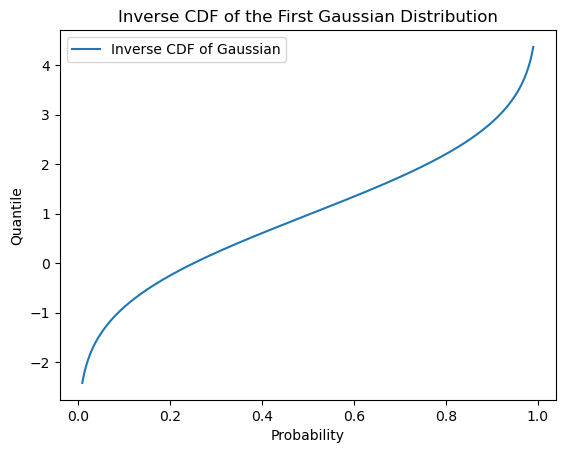

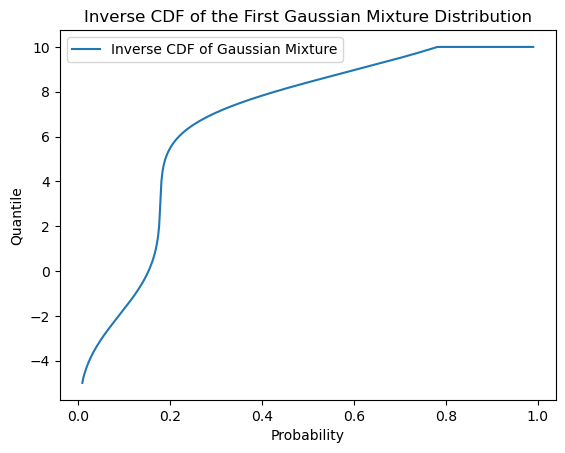

In [40]:
# Plotting the inverse CDF
plt.plot(probabilities, inverse_cdf_values, label="Inverse CDF of Gaussian")
plt.xlabel("Probability")
plt.ylabel("Quantile")
plt.title("Inverse CDF of the First Gaussian Distribution")
plt.legend()
plt.show()

# Implement compute_gaussian_mixture_cdf_and_inverse
# Example: First Gaussian Mixture
# Compute the inverse CDF for the first Gaussian mixture in the dataset
components = gaussian_mixtures[0]
_, inverse_cdf_fn_gm = compute_gaussian_mixture_cdf_and_inverse(
    x_range, components)
# Extract the values from the interpolating object for plotting
inverse_cdf_values_gm = inverse_cdf_fn_gm(
    probabilities
)  # Extracting values for plotting by calling the interpolating function with probabilities
# Plotting the extracted values of inverse CDF for Gaussian Mixture
plt.plot(probabilities,
         inverse_cdf_values_gm,
         label="Inverse CDF of Gaussian Mixture")
plt.xlabel("Probability")
plt.ylabel("Quantile")
plt.title("Inverse CDF of the First Gaussian Mixture Distribution")
plt.legend()
plt.show()

In [41]:
### STEP 3: Apply Cumulative Distribution Transform (CDT) to all densities in both datasets
def transform_points_through_inverse_cdf(points, inverse_cdf_fn):
  """
  Transforms points through a given inverse CDF function.

  Args:
  points (np.array): Array of points to transform.
  inverse_cdf_fn (callable): Function to use as the inverse CDF.

  Returns:
  np.array: Transformed points.
  """
  # Normalize points to be in the range of probabilities for inverse CDF transformation
  normalized_points = (points - np.min(points)) / (np.max(points) -
                                                   np.min(points))
  # Apply inverse CDF to transform points
  transformed_points = inverse_cdf_fn(normalized_points)
  return transformed_points


# Apply CDT to the first Gaussian and first Gaussian Mixture as examples
# Transform for a Gaussian
uniform_points = np.random.uniform(low=0.01, high=0.99, size=400)
transformed_gaussian = transform_points_through_inverse_cdf(
    uniform_points, lambda x: inverse_cdf_values)
# Transform for a Gaussian Mixture using the interpolating inverse CDF function
transformed_gaussian_mixture = transform_points_through_inverse_cdf(
    uniform_points, inverse_cdf_fn_gm)

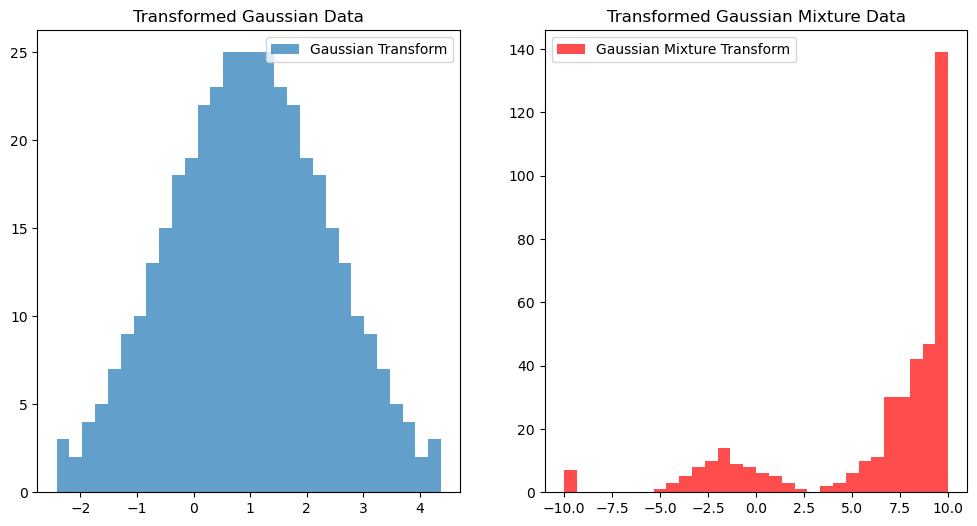

In [42]:
# Plot to Verify the Transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(transformed_gaussian, bins=30, alpha=0.7, label='Gaussian Transform')
plt.title('Transformed Gaussian Data')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(transformed_gaussian_mixture,
         bins=30,
         alpha=0.7,
         color='red',
         label='Gaussian Mixture Transform')
plt.title('Transformed Gaussian Mixture Data')
plt.legend()
plt.show()

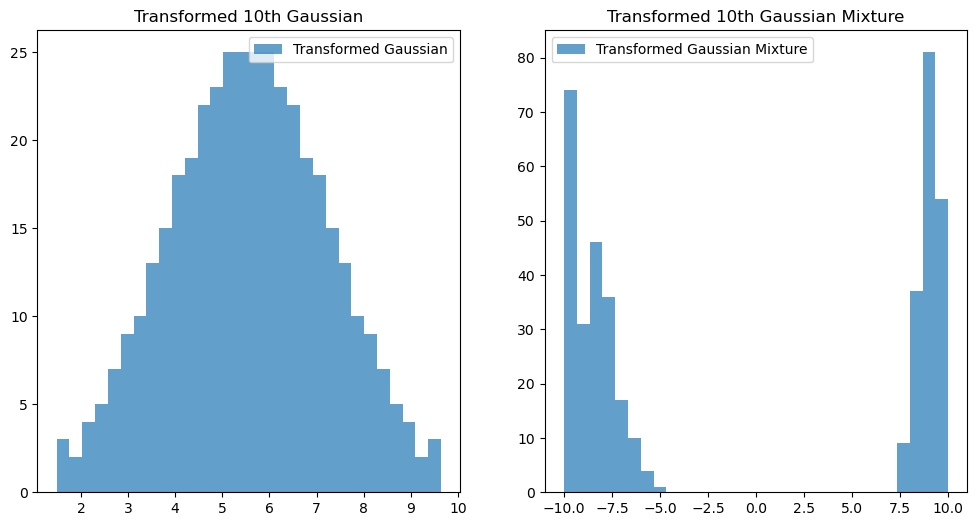

In [43]:
# Apply CDT to all elements in gaussians and gaussian_mixtures
# Transformation of all Gaussians
transformed_gaussians = [
    transform_points_through_inverse_cdf(
        np.random.uniform(low=0.01, high=0.99, size=400),
        lambda x: compute_cdf_and_inverse_cdf_gaussian(gaussian, x_range)[1])
    for gaussian in gaussians
]
# Transformation of all Gaussian Mixtures
transformed_gaussian_mixtures = []
for mixture in gaussian_mixtures:
  _, inverse_cdf_fn = compute_gaussian_mixture_cdf_and_inverse(
      x_range, mixture)
  transformed_mixture = transform_points_through_inverse_cdf(
      np.random.uniform(low=0.01, high=0.99, size=400), inverse_cdf_fn)
  transformed_gaussian_mixtures.append(transformed_mixture)

# Example plotting for the 10th Gaussian and Gaussian mixture transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(transformed_gaussians[9],
         bins=30,
         alpha=0.7,
         label='Transformed Gaussian')
plt.title('Transformed 10th Gaussian')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(transformed_gaussian_mixtures[9],
         bins=30,
         alpha=0.7,
         label='Transformed Gaussian Mixture')
plt.title('Transformed 10th Gaussian Mixture')
plt.legend()
plt.show()

In [44]:
### STEP 4: Use the linear classifiers PCA and LDA to perform classification on the Gaussian and Gaussian Mixture datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Function to plot decision boundaries using LDA classifier
def plot_decision_boundaries(X, y, classifier, test_idx=None, resolution=0.02):
  # Setup marker generator and color map
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])
  # Plot the decision surface
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())
  # Plot all samples
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha=0.8,
                c=colors[idx],
                marker=markers[idx],
                label=cl,
                edgecolor='black')

  # Highlight test samples
  if test_idx:
    X_test, y_test = X[test_idx, :], y[test_idx]
    plt.scatter(X_test[:, 0],
                X_test[:, 1],
                c='',
                edgecolor='black',
                alpha=1.0,
                linewidth=1,
                marker='o',
                s=100,
                label='test set')

    
# Step 1: Combine the datasets
# Assuming `transformed_gaussians` and `transformed_gaussian_mixtures` are lists of arrays.
all_transformed_data = np.array(transformed_gaussians +
                                transformed_gaussian_mixtures)
labels = np.array([0] * len(transformed_gaussians) +
                  [1] * len(transformed_gaussian_mixtures))
# Flatten the data because PCA and LDA expect features to be in columns
all_transformed_data_flat = all_transformed_data.reshape(
    all_transformed_data.shape[0], -1)
# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(all_transformed_data_flat,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)
# Step 2: Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Adjust n_components based on your needs
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Step 3: Fit an LDA model on the PCA-transformed training data
lda = LDA()
lda.fit(X_train_pca, y_train)
# Step 4: Transform the test data using PCA and predict using LDA
y_pred = lda.predict(X_test_pca)
# Step 5: Calculate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8500


C:\Users\Kaitlyn\AppData\Local\Temp\ipykernel_13276\3642784770.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\Kaitlyn\AppData\Local\Temp\ipykernel_13276\3642784770.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


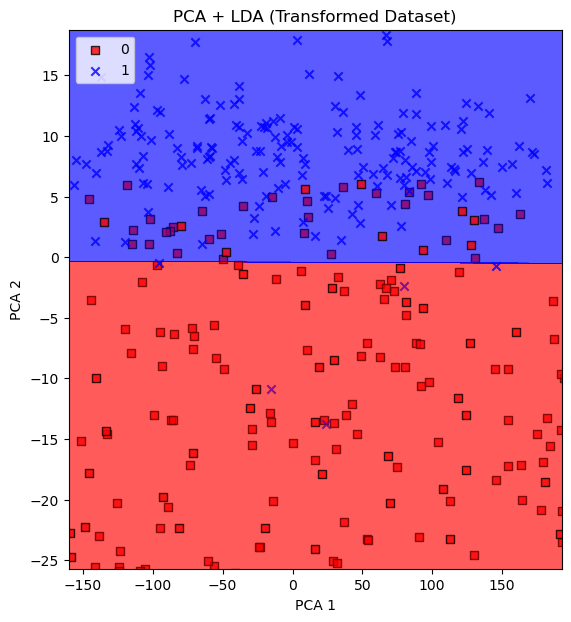

In [45]:
# Visualize the PCA results for the transformed dataset
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plot_decision_boundaries(X_train_pca, y_train, lda, resolution=0.02)
plt.title('PCA + LDA (Transformed Dataset)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper left')
# Visualize decision boundaries for the test set; 0 is Gaussian, 1 is Gaussian mixture
plot_decision_boundaries(X_test_pca, y_test, lda, resolution=0.02)
plt.show()

In [46]:
### STEP 5: Use PCA, LDA directly on the original data and compare results
# Assume we create feature vectors by sampling from each distribution
def sample_from_gaussian(mean_std_dev_tuple, num_samples=100):
  mean, std = mean_std_dev_tuple
  return np.random.normal(mean, std, num_samples)


def sample_from_gaussian_mixture(components, num_samples=100):
  samples = np.zeros(num_samples)
  for mean, std, weight in components:
    ns = int(num_samples * weight)
    samples[:ns] += np.random.normal(mean, std, ns)
  np.random.shuffle(samples)
  return samples


# Create feature vectors
gaussian_features = np.array([sample_from_gaussian(g) for g in gaussians])
gaussian_mixture_features = np.array(
    [sample_from_gaussian_mixture(gm) for gm in gaussian_mixtures])
# Flatten the features to fit ML models
gaussian_features_flat = gaussian_features.reshape(gaussian_features.shape[0],
                                                   -1)
gaussian_mixture_features_flat = gaussian_mixture_features.reshape(
    gaussian_mixture_features.shape[0], -1)
# Combine the datasets and create labels
all_data_flat = np.vstack(
    (gaussian_features_flat, gaussian_mixture_features_flat))
labels = np.array([0] * len(gaussian_features_flat) +
                  [1] * len(gaussian_mixture_features_flat))
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(all_data_flat,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)
# Apply PCA
pca = PCA(n_components=2)  # Adjust based on your needs
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Train LDA
lda = LDA()
lda.fit(X_train_pca, y_train)
# Predict and calculate accuracy
y_pred = lda.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4250


C:\Users\Kaitlyn\AppData\Local\Temp\ipykernel_13276\3642784770.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\Kaitlyn\AppData\Local\Temp\ipykernel_13276\3642784770.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


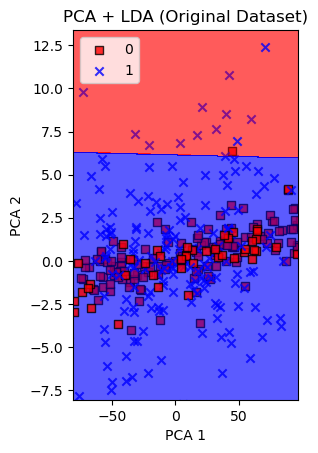

In [47]:
# Flatten the original data, sample labels, and apply PCA
X_train_pca_original = pca.fit_transform(X_train)
X_test_pca_original = pca.transform(X_test)
# Visualize the PCA results for the original dataset
plt.subplot(1, 2, 2)
plot_decision_boundaries(X_train_pca_original, y_train, lda, resolution=0.02)
plt.title('PCA + LDA (Original Dataset)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper left')
# Optionally, plot decision boundaries for the original test set
plot_decision_boundaries(X_test_pca_original, y_test, lda, resolution=0.02)
plt.show()